# Optimization of CNN - TPE

In this notebook, we will optimize the hyperparameters of a CNN using the define-by-run model from Optuna.

In [1]:
# For reproducible results.
# See: 
# https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development

import os
os.environ['PYTHONHASHSEED'] = '0'

import numpy as np
import tensorflow as tf
import random as python_random

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(123)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
python_random.seed(123)

# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/random/set_seed
tf.random.set_seed(1234)

In [2]:
import itertools
from functools import partial

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [3]:
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam, RMSprop

In [4]:
import optuna

#  Data Preparation

The dataset contains information about images, each image is a hand-written digit. The aim is to have the computer predict which digit was written by the person, automatically, by "looking" at the image. 

Each image is 28 pixels in height and 28 pixels in width (28 x 28), making a total of 784 pixels. Each pixel value is an integer between 0 and 255, indicating the darkness in a gray-scale of that pixel.

The data is stored in a dataframe where each each pixel is a column (so it is flattened and not in the 28 x 28 format). 

The data set the has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.

In [5]:
# Load the data

data = pd.read_csv("../mnist.csv")

# first column is the target, the rest of the columns
# are the pixels of the image

# each row is 1 image
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# split dataset into a train and test set

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['label'], axis=1), # the images
    data['label'], # the target
    test_size = 0.1,
    random_state=0)

X_train.shape, X_test.shape

((37800, 784), (4200, 784))

Text(0, 0.5, 'Number of images')

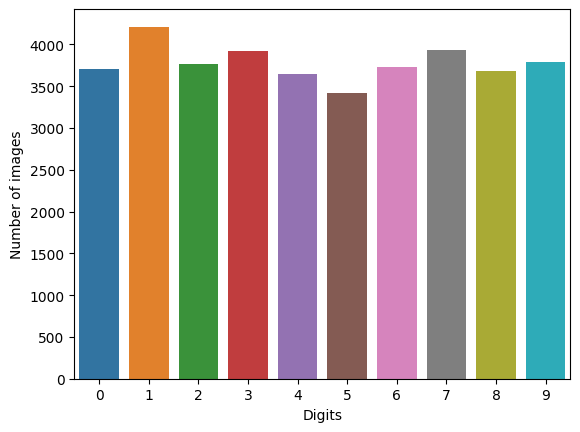

In [7]:
# number of images for each digit

g = sns.countplot(x=y_train)
plt.xlabel('Digits')
plt.ylabel('Number of images')

There are roughly the same amount of images for each of the 10 digits.

## Image re-scaling

We re-scale data for the CNN, between 0 and 1.

In [8]:
# Re-scale the data

# 255 is the maximum value a pixel can take

X_train = X_train / 255
X_test = X_test / 255

## Reshape

The images were stored in a pandas dataframe as 1-D vectors of 784 values. For a CNN with Keras, we need tensors with the following dimensions: width x height x channel. 

Thus, we reshape all data to 28 x 2 8 x 1, 3-D matrices. 

The 3rd dimension corresponds to the channel. RGB images have 3 channels. MNIST images are in gray-scale, thus they have only one channel in the 3rd dimension.

In [9]:
# Reshape image in 3 dimensions:
# height: 28px X width: 28px X channel: 1 

X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)

## Target encoding

In [10]:
# the target is 1 variable with the 9 different digits
# as values

y_train.unique()

array([2, 0, 7, 4, 3, 5, 9, 6, 8, 1], dtype=int64)

In [11]:
# For Keras, we need to create 10 dummy variables,
# one for each digit

# Encode labels to one hot vectors (ex : digit 2 -> [0,0,1,0,0,0,0,0,0,0])

y_train = to_categorical(y_train, num_classes = 10)
y_test = to_categorical(y_test, num_classes = 10)

# the new target
y_train

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

Let's print some example images.

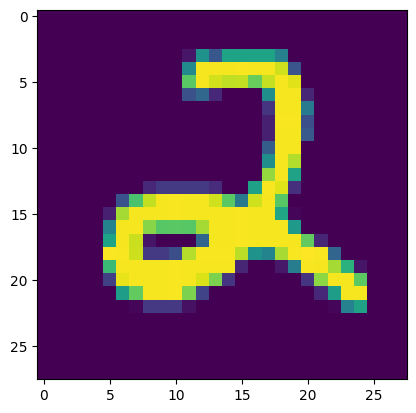

In [12]:
# Some image examples 

g = plt.imshow(X_train[0][:,:,0])

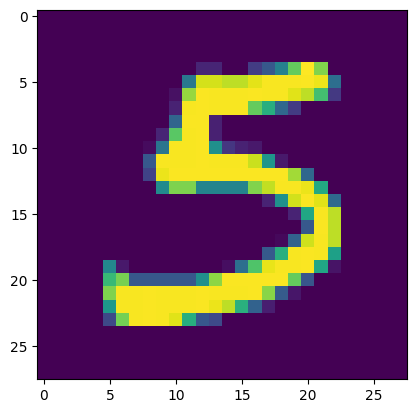

In [13]:
# Some image examples 

g = plt.imshow(X_train[10][:,:,0])

# Define-by-Run design

We create the CNN and add the sampling space for the hyperparameters as we go. This is the Desing-by-run concept.

In [14]:
# we will save the model with this name
path_best_model = 'cnn_model.h5'

# starting point for the optimization
best_accuracy = 0

In [15]:
# function to create the CNN

def objective(trial):

    # Start construction of a Keras Sequential model.
    model = Sequential()

    # Convolutional layers.

    # We add the different number of conv layers in the following loop:
    num_conv_layers = trial.suggest_int('num_conv_layers', 1, 3)

    for i in range(num_conv_layers):
        
        # NOTE: As per the below configuration, the parameters of each
        # convolutional layer will be identical.
        
        # if we want different parameters in each layer, check next
        # notebook

        model.add(Conv2D(
            filters=trial.suggest_categorical('filters', [16, 32, 64]),
            kernel_size=trial.suggest_categorical('kernel_size', [3, 5]),
            strides=trial.suggest_categorical('strides', [1, 2]),
            activation=trial.suggest_categorical(
                'activation', ['relu', 'tanh']),
            padding='same',
        ))

    # we could also optimize these parameters if we wanted:
    model.add(MaxPool2D(pool_size=2, strides=2))

    # Flatten the 4-rank output of the convolutional layers
    # to 2-rank that can be input to a fully-connected Dense layer.
    model.add(Flatten())

    # Add fully-connected Dense layers.
    # The number of layers is a hyper-parameter we want to optimize.
    # We add the different number of layers in the following loop:

    num_dense_layers = trial.suggest_int('num_dense_layers', 1, 3)

    for i in range(num_dense_layers):

        # Add the dense fully-connected layer to the model.
        # This has two hyper-parameters we want to optimize:
        # The number of nodes (neurons) and the activation function.
        model.add(Dense(
            units=trial.suggest_int('units', 5, 512),
            activation=trial.suggest_categorical(
                'activation', ['relu', 'tanh']),
        ))

    # Last fully-connected dense layer with softmax-activation
    # for use in classification.
    model.add(Dense(10, activation='softmax'))

    # Use the Adam method for training the network.
    optimizer_name = trial.suggest_categorical(
        'optimizer_name', ['Adam', 'RMSprop'])

    if optimizer_name == 'Adam':
        optimizer = Adam(lr=trial.suggest_float('learning_rate',  1e-6, 1e-2))
    else:
        optimizer = RMSprop(
            lr=trial.suggest_float('learning_rate',  1e-6, 1e-2),
            momentum=trial.suggest_float('momentum',  0.1, 0.9),
        )

    # In Keras we need to compile the model so it can be trained.
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # train the model
    # we use 3 epochs to be able to run the notebook in a "reasonable"
    # time. If we increase the epochs, we will have better performance
    # this could be another parameter to optimize in fact.
    history = model.fit(
        x=X_train,
        y=y_train,
        epochs=3,
        batch_size=128,
        validation_split=0.1,
    )

    # Get the classification accuracy on the validation-set
    # after the last training-epoch.
    accuracy = history.history['val_accuracy'][-1]

    # Save the model if it improves on the best-found performance.
    # We use the global keyword so we update the variable outside
    # of this function.
    global best_accuracy

    # If the classification accuracy of the saved model is improved ...
    if accuracy > best_accuracy:
        # Save the new model to harddisk.
        # Training CNNs is costly, so we want to avoid having to re-train
        # the network with the best found parameters. We save it instead
        # as we search for the best hyperparam space.
        model.save(path_best_model)

        # Update the classification accuracy.
        best_accuracy = accuracy

    # Delete the Keras model with these hyper-parameters from memory.
    del model

    # Remember that Scikit-optimize always minimizes the objective
    # function, so we need to negate the accuracy (because we want
    # the maximum accuracy)
    return accuracy

In [16]:
# we need this to store the search
# we will use it in the following notebook

study_name = "cnn_study"  # unique identifier of the study.
storage_name = "sqlite:///{}.db".format(study_name)

In [ ]:
study = optuna.create_study(
    direction='maximize',
    study_name=study_name,
#    storage=storage_name,
    load_if_exists=True,
)

study.optimize(objective, n_trials=30)

[I 2023-09-19 15:24:53,885] A new study created in memory with name: cnn_study
C:\Users\mainn.ho\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/3
266/266 [==============================] - 11s 37ms/step - loss: 0.2621 - accuracy: 0.9139 - val_loss: 0.1259 - val_accuracy: 0.9661
Epoch 2/3
266/266 [==============================] - 9s 35ms/step - loss: 0.0817 - accuracy: 0.9754 - val_loss: 0.1099 - val_accuracy: 0.9709
Epoch 3/3
266/266 [==============================] - 10s 36ms/step - loss: 0.0631 - accuracy: 0.9823 - val_loss: 0.1005 - val_accuracy: 0.9733


[I 2023-09-19 15:25:24,537] Trial 0 finished with value: 0.9732804298400879 and parameters: {'num_conv_layers': 3, 'filters': 32, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 2, 'units': 245, 'optimizer_name': 'Adam', 'learning_rate': 0.006057748440064741}. Best is trial 0 with value: 0.9732804298400879.
C:\Users\mainn.ho\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\legacy\rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/3
266/266 [==============================] - 68s 255ms/step - loss: 0.7188 - accuracy: 0.7479 - val_loss: 0.1463 - val_accuracy: 0.9582
Epoch 2/3
266/266 [==============================] - 65s 245ms/step - loss: 0.1214 - accuracy: 0.9659 - val_loss: 0.1001 - val_accuracy: 0.9743
Epoch 3/3
266/266 [==============================] - 68s 255ms/step - loss: 0.0791 - accuracy: 0.9775 - val_loss: 0.0818 - val_accuracy: 0.9788


[I 2023-09-19 15:28:46,297] Trial 1 finished with value: 0.9788359999656677 and parameters: {'num_conv_layers': 2, 'filters': 64, 'kernel_size': 3, 'strides': 1, 'activation': 'relu', 'num_dense_layers': 3, 'units': 380, 'optimizer_name': 'RMSprop', 'learning_rate': 0.005860756116850315, 'momentum': 0.13076730491217037}. Best is trial 1 with value: 0.9788359999656677.


Epoch 1/3
266/266 [==============================] - 23s 85ms/step - loss: 4.0933 - accuracy: 0.0975 - val_loss: 3.6485 - val_accuracy: 0.0997
Epoch 2/3
266/266 [==============================] - 24s 89ms/step - loss: 3.8413 - accuracy: 0.0995 - val_loss: 4.0772 - val_accuracy: 0.0997
Epoch 3/3
266/266 [==============================] - 24s 91ms/step - loss: 3.8651 - accuracy: 0.0987 - val_loss: 3.0540 - val_accuracy: 0.1037


[I 2023-09-19 15:29:57,296] Trial 2 finished with value: 0.10370370000600815 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 5, 'strides': 1, 'activation': 'tanh', 'num_dense_layers': 3, 'units': 325, 'optimizer_name': 'RMSprop', 'learning_rate': 0.009302280739168098, 'momentum': 0.5097028407922235}. Best is trial 1 with value: 0.9788359999656677.


Epoch 1/3
266/266 [==============================] - 5s 17ms/step - loss: 0.2607 - accuracy: 0.9167 - val_loss: 0.1119 - val_accuracy: 0.9672
Epoch 2/3
266/266 [==============================] - 4s 16ms/step - loss: 0.0942 - accuracy: 0.9717 - val_loss: 0.0922 - val_accuracy: 0.9738
Epoch 3/3
266/266 [==============================] - 4s 16ms/step - loss: 0.0682 - accuracy: 0.9789 - val_loss: 0.0895 - val_accuracy: 0.9730


[I 2023-09-19 15:30:11,114] Trial 3 finished with value: 0.9730158448219299 and parameters: {'num_conv_layers': 3, 'filters': 32, 'kernel_size': 3, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 1, 'units': 75, 'optimizer_name': 'Adam', 'learning_rate': 0.009231709036622657}. Best is trial 1 with value: 0.9788359999656677.


Epoch 1/3
266/266 [==============================] - 8s 28ms/step - loss: 0.2399 - accuracy: 0.9260 - val_loss: 0.1600 - val_accuracy: 0.9542
Epoch 2/3
266/266 [==============================] - 8s 29ms/step - loss: 0.0825 - accuracy: 0.9747 - val_loss: 0.0938 - val_accuracy: 0.9749
Epoch 3/3
266/266 [==============================] - 9s 34ms/step - loss: 0.0451 - accuracy: 0.9859 - val_loss: 0.0824 - val_accuracy: 0.9754


[I 2023-09-19 15:30:36,000] Trial 4 finished with value: 0.9753968119621277 and parameters: {'num_conv_layers': 1, 'filters': 16, 'kernel_size': 5, 'strides': 1, 'activation': 'tanh', 'num_dense_layers': 2, 'units': 212, 'optimizer_name': 'Adam', 'learning_rate': 0.0024229627577129283}. Best is trial 1 with value: 0.9788359999656677.


Epoch 1/3
266/266 [==============================] - 16s 59ms/step - loss: 0.2238 - accuracy: 0.9335 - val_loss: 0.1118 - val_accuracy: 0.9667
Epoch 2/3
266/266 [==============================] - 16s 62ms/step - loss: 0.0683 - accuracy: 0.9795 - val_loss: 0.0748 - val_accuracy: 0.9788
Epoch 3/3
266/266 [==============================] - 16s 59ms/step - loss: 0.0422 - accuracy: 0.9873 - val_loss: 0.0711 - val_accuracy: 0.9788


[I 2023-09-19 15:31:24,451] Trial 5 finished with value: 0.9788359999656677 and parameters: {'num_conv_layers': 1, 'filters': 32, 'kernel_size': 3, 'strides': 1, 'activation': 'relu', 'num_dense_layers': 1, 'units': 505, 'optimizer_name': 'Adam', 'learning_rate': 0.0009743493262007424}. Best is trial 1 with value: 0.9788359999656677.


Epoch 1/3
266/266 [==============================] - 23s 83ms/step - loss: 0.2398 - accuracy: 0.9259 - val_loss: 0.1395 - val_accuracy: 0.9595
Epoch 2/3
266/266 [==============================] - 20s 76ms/step - loss: 0.0890 - accuracy: 0.9724 - val_loss: 0.1266 - val_accuracy: 0.9630
Epoch 3/3
266/266 [==============================] - 20s 75ms/step - loss: 0.0636 - accuracy: 0.9801 - val_loss: 0.1151 - val_accuracy: 0.9693


[I 2023-09-19 15:32:27,144] Trial 6 finished with value: 0.9693121910095215 and parameters: {'num_conv_layers': 1, 'filters': 64, 'kernel_size': 3, 'strides': 1, 'activation': 'tanh', 'num_dense_layers': 2, 'units': 196, 'optimizer_name': 'Adam', 'learning_rate': 0.005497761887873039}. Best is trial 1 with value: 0.9788359999656677.


Epoch 1/3
266/266 [==============================] - 71s 267ms/step - loss: 3.0480 - accuracy: 0.3306 - val_loss: 4.0328 - val_accuracy: 0.1487
Epoch 2/3
266/266 [==============================] - 73s 274ms/step - loss: 2.2934 - accuracy: 0.4036 - val_loss: 2.0035 - val_accuracy: 0.3606
Epoch 3/3
266/266 [==============================] - 73s 273ms/step - loss: 1.2668 - accuracy: 0.6354 - val_loss: 1.0341 - val_accuracy: 0.6354


[I 2023-09-19 15:36:04,161] Trial 7 finished with value: 0.6354497075080872 and parameters: {'num_conv_layers': 2, 'filters': 64, 'kernel_size': 3, 'strides': 1, 'activation': 'tanh', 'num_dense_layers': 1, 'units': 499, 'optimizer_name': 'RMSprop', 'learning_rate': 0.005451760132906189, 'momentum': 0.7719992114213331}. Best is trial 1 with value: 0.9788359999656677.


Epoch 1/3
266/266 [==============================] - 16s 57ms/step - loss: 0.2618 - accuracy: 0.9168 - val_loss: 0.0996 - val_accuracy: 0.9722
Epoch 2/3
266/266 [==============================] - 14s 53ms/step - loss: 0.0690 - accuracy: 0.9794 - val_loss: 0.0907 - val_accuracy: 0.9749
Epoch 3/3
266/266 [==============================] - 14s 52ms/step - loss: 0.0482 - accuracy: 0.9864 - val_loss: 0.0740 - val_accuracy: 0.9841


[I 2023-09-19 15:36:47,790] Trial 8 finished with value: 0.9841269850730896 and parameters: {'num_conv_layers': 3, 'filters': 64, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 2, 'units': 223, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0006410691656069797, 'momentum': 0.773756061018062}. Best is trial 8 with value: 0.9841269850730896.


Epoch 1/3
266/266 [==============================] - 4s 15ms/step - loss: 0.2824 - accuracy: 0.9083 - val_loss: 0.1327 - val_accuracy: 0.9614
Epoch 2/3
266/266 [==============================] - 4s 14ms/step - loss: 0.0961 - accuracy: 0.9702 - val_loss: 0.0799 - val_accuracy: 0.9746
Epoch 3/3
266/266 [==============================] - 4s 14ms/step - loss: 0.0698 - accuracy: 0.9792 - val_loss: 0.1129 - val_accuracy: 0.9690


[I 2023-09-19 15:36:59,766] Trial 9 finished with value: 0.9690476059913635 and parameters: {'num_conv_layers': 2, 'filters': 32, 'kernel_size': 3, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 3, 'units': 336, 'optimizer_name': 'Adam', 'learning_rate': 0.004621900203437648}. Best is trial 8 with value: 0.9841269850730896.


Epoch 1/3
266/266 [==============================] - 5s 17ms/step - loss: 0.6012 - accuracy: 0.7987 - val_loss: 0.2364 - val_accuracy: 0.9286
Epoch 2/3
266/266 [==============================] - 5s 18ms/step - loss: 0.1560 - accuracy: 0.9534 - val_loss: 0.1241 - val_accuracy: 0.9648
Epoch 3/3
266/266 [==============================] - 5s 17ms/step - loss: 0.1089 - accuracy: 0.9675 - val_loss: 0.1223 - val_accuracy: 0.9638


[I 2023-09-19 15:37:14,223] Trial 10 finished with value: 0.9637566208839417 and parameters: {'num_conv_layers': 3, 'filters': 16, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 2, 'units': 19, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0002890128332968594, 'momentum': 0.8862363644994864}. Best is trial 8 with value: 0.9841269850730896.


Epoch 1/3
266/266 [==============================] - 14s 49ms/step - loss: 0.4526 - accuracy: 0.8532 - val_loss: 0.1547 - val_accuracy: 0.9550
Epoch 2/3
266/266 [==============================] - 15s 58ms/step - loss: 0.0909 - accuracy: 0.9747 - val_loss: 0.0870 - val_accuracy: 0.9749
Epoch 3/3
266/266 [==============================] - 14s 53ms/step - loss: 0.0623 - accuracy: 0.9822 - val_loss: 0.0958 - val_accuracy: 0.9775


[I 2023-09-19 15:37:57,472] Trial 11 finished with value: 0.9775132536888123 and parameters: {'num_conv_layers': 2, 'filters': 64, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 3, 'units': 383, 'optimizer_name': 'RMSprop', 'learning_rate': 0.002935285845275064, 'momentum': 0.11271320059077086}. Best is trial 8 with value: 0.9841269850730896.


Epoch 1/3
266/266 [==============================] - 111s 415ms/step - loss: 2.3119 - accuracy: 0.1073 - val_loss: 2.3019 - val_accuracy: 0.0997
Epoch 2/3
266/266 [==============================] - 97s 363ms/step - loss: 2.3020 - accuracy: 0.1097 - val_loss: 2.3012 - val_accuracy: 0.1146
Epoch 3/3
266/266 [==============================] - 101s 380ms/step - loss: 2.3019 - accuracy: 0.1106 - val_loss: 2.3024 - val_accuracy: 0.1146


[I 2023-09-19 15:43:06,419] Trial 12 finished with value: 0.11455026268959045 and parameters: {'num_conv_layers': 3, 'filters': 64, 'kernel_size': 3, 'strides': 1, 'activation': 'relu', 'num_dense_layers': 3, 'units': 416, 'optimizer_name': 'RMSprop', 'learning_rate': 0.007334740235212123, 'momentum': 0.2252329051889128}. Best is trial 8 with value: 0.9841269850730896.


Epoch 1/3
266/266 [==============================] - 12s 43ms/step - loss: 0.2932 - accuracy: 0.9029 - val_loss: 0.0950 - val_accuracy: 0.9712
Epoch 2/3
266/266 [==============================] - 12s 44ms/step - loss: 0.0854 - accuracy: 0.9735 - val_loss: 0.0797 - val_accuracy: 0.9786
Epoch 3/3
266/266 [==============================] - 12s 44ms/step - loss: 0.0658 - accuracy: 0.9801 - val_loss: 0.0985 - val_accuracy: 0.9704


[I 2023-09-19 15:43:41,912] Trial 13 finished with value: 0.970370352268219 and parameters: {'num_conv_layers': 2, 'filters': 64, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 2, 'units': 182, 'optimizer_name': 'RMSprop', 'learning_rate': 0.003561361085368137, 'momentum': 0.4052908668434914}. Best is trial 8 with value: 0.9841269850730896.


Epoch 1/3
266/266 [==============================] - 124s 465ms/step - loss: 0.2078 - accuracy: 0.9330 - val_loss: 0.0876 - val_accuracy: 0.9743
Epoch 2/3
266/266 [==============================] - 134s 504ms/step - loss: 0.0685 - accuracy: 0.9811 - val_loss: 0.0786 - val_accuracy: 0.9796
Epoch 3/3
266/266 [==============================] - 222s 836ms/step - loss: 0.0475 - accuracy: 0.9882 - val_loss: 0.0747 - val_accuracy: 0.9815


[I 2023-09-19 15:51:42,321] Trial 14 finished with value: 0.9814814925193787 and parameters: {'num_conv_layers': 2, 'filters': 64, 'kernel_size': 5, 'strides': 1, 'activation': 'relu', 'num_dense_layers': 3, 'units': 135, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0016302015083853793, 'momentum': 0.6472516134916936}. Best is trial 8 with value: 0.9841269850730896.


Epoch 1/3
266/266 [==============================] - 33s 113ms/step - loss: 0.2611 - accuracy: 0.9171 - val_loss: 0.0973 - val_accuracy: 0.9728
Epoch 2/3
266/266 [==============================] - 31s 115ms/step - loss: 0.0739 - accuracy: 0.9788 - val_loss: 0.0845 - val_accuracy: 0.9770
Epoch 3/3
266/266 [==============================] - 31s 118ms/step - loss: 0.0538 - accuracy: 0.9845 - val_loss: 0.1233 - val_accuracy: 0.9722


[I 2023-09-19 15:53:19,361] Trial 15 finished with value: 0.9722222089767456 and parameters: {'num_conv_layers': 3, 'filters': 64, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 2, 'units': 111, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0014362011878741592, 'momentum': 0.6840748886388437}. Best is trial 8 with value: 0.9841269850730896.


Epoch 1/3
266/266 [==============================] - 55s 201ms/step - loss: 0.7526 - accuracy: 0.7969 - val_loss: 0.3098 - val_accuracy: 0.9034
Epoch 2/3
266/266 [==============================] - 54s 202ms/step - loss: 0.2330 - accuracy: 0.9291 - val_loss: 0.2064 - val_accuracy: 0.9405
Epoch 3/3
266/266 [==============================] - 61s 230ms/step - loss: 0.1562 - accuracy: 0.9526 - val_loss: 0.1584 - val_accuracy: 0.9556


[I 2023-09-19 15:56:10,551] Trial 16 finished with value: 0.9555555582046509 and parameters: {'num_conv_layers': 2, 'filters': 16, 'kernel_size': 5, 'strides': 1, 'activation': 'relu', 'num_dense_layers': 3, 'units': 136, 'optimizer_name': 'RMSprop', 'learning_rate': 4.4611140877958344e-05, 'momentum': 0.6534856698386541}. Best is trial 8 with value: 0.9841269850730896.


Epoch 1/3
266/266 [==============================] - 36s 126ms/step - loss: 0.3721 - accuracy: 0.8823 - val_loss: 0.1680 - val_accuracy: 0.9585
Epoch 2/3
266/266 [==============================] - 29s 108ms/step - loss: 0.1109 - accuracy: 0.9700 - val_loss: 0.1257 - val_accuracy: 0.9706
Epoch 3/3
266/266 [==============================] - 32s 121ms/step - loss: 0.0913 - accuracy: 0.9766 - val_loss: 0.1294 - val_accuracy: 0.9720


[I 2023-09-19 15:57:57,218] Trial 17 finished with value: 0.9719576835632324 and parameters: {'num_conv_layers': 3, 'filters': 64, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 1, 'units': 9, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0015419580077247687, 'momentum': 0.890579317979917}. Best is trial 8 with value: 0.9841269850730896.


Epoch 1/3
266/266 [==============================] - 295s 1s/step - loss: 2.4999 - accuracy: 0.0999 - val_loss: 2.3607 - val_accuracy: 0.1079
Epoch 2/3
266/266 [==============================] - 284s 1s/step - loss: 2.3959 - accuracy: 0.1019 - val_loss: 2.4042 - val_accuracy: 0.1037
Epoch 3/3
266/266 [==============================] - 282s 1s/step - loss: 2.3909 - accuracy: 0.1023 - val_loss: 2.4125 - val_accuracy: 0.0868


[I 2023-09-19 16:12:18,722] Trial 18 finished with value: 0.08677248656749725 and parameters: {'num_conv_layers': 2, 'filters': 64, 'kernel_size': 5, 'strides': 1, 'activation': 'tanh', 'num_dense_layers': 2, 'units': 297, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0021046904841015013, 'momentum': 0.5998167387597523}. Best is trial 8 with value: 0.9841269850730896.


Epoch 1/3
266/266 [==============================] - 11s 35ms/step - loss: 0.2735 - accuracy: 0.9129 - val_loss: 0.1402 - val_accuracy: 0.9598
Epoch 2/3
266/266 [==============================] - 8s 31ms/step - loss: 0.1276 - accuracy: 0.9643 - val_loss: 0.1849 - val_accuracy: 0.9532
Epoch 3/3
266/266 [==============================] - 8s 30ms/step - loss: 0.1200 - accuracy: 0.9674 - val_loss: 0.1531 - val_accuracy: 0.9627


[I 2023-09-19 16:12:47,820] Trial 19 finished with value: 0.9626984000205994 and parameters: {'num_conv_layers': 2, 'filters': 16, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 2, 'units': 146, 'optimizer_name': 'RMSprop', 'learning_rate': 0.003466108913835271, 'momentum': 0.7659780672515792}. Best is trial 8 with value: 0.9841269850730896.


Epoch 1/3
266/266 [==============================] - 30s 107ms/step - loss: 0.3366 - accuracy: 0.8909 - val_loss: 0.1170 - val_accuracy: 0.9651
Epoch 2/3
266/266 [==============================] - 26s 99ms/step - loss: 0.0771 - accuracy: 0.9771 - val_loss: 0.0891 - val_accuracy: 0.9751
Epoch 3/3
266/266 [==============================] - 26s 98ms/step - loss: 0.0511 - accuracy: 0.9844 - val_loss: 0.0801 - val_accuracy: 0.9817


[I 2023-09-19 16:14:11,071] Trial 20 finished with value: 0.9817460179328918 and parameters: {'num_conv_layers': 3, 'filters': 64, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 3, 'units': 78, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0009865965585339517, 'momentum': 0.5055813954210004}. Best is trial 8 with value: 0.9841269850730896.


Epoch 1/3
266/266 [==============================] - 29s 100ms/step - loss: 0.3358 - accuracy: 0.8905 - val_loss: 0.1102 - val_accuracy: 0.9661
Epoch 2/3
266/266 [==============================] - 28s 105ms/step - loss: 0.0820 - accuracy: 0.9758 - val_loss: 0.0801 - val_accuracy: 0.9772
Epoch 3/3
266/266 [==============================] - 27s 103ms/step - loss: 0.0536 - accuracy: 0.9842 - val_loss: 0.1012 - val_accuracy: 0.9741


[I 2023-09-19 16:15:36,067] Trial 21 finished with value: 0.9740740656852722 and parameters: {'num_conv_layers': 3, 'filters': 64, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 3, 'units': 73, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0008572371224219785, 'momentum': 0.5368380209747229}. Best is trial 8 with value: 0.9841269850730896.


Epoch 1/3
266/266 [==============================] - 31s 109ms/step - loss: 1.8709 - accuracy: 0.4663 - val_loss: 1.0199 - val_accuracy: 0.7228
Epoch 2/3
266/266 [==============================] - 30s 112ms/step - loss: 0.5889 - accuracy: 0.8396 - val_loss: 0.4290 - val_accuracy: 0.8704
Epoch 3/3
266/266 [==============================] - 28s 104ms/step - loss: 0.3588 - accuracy: 0.8934 - val_loss: 0.3385 - val_accuracy: 0.8987


[I 2023-09-19 16:17:05,281] Trial 22 finished with value: 0.8986772298812866 and parameters: {'num_conv_layers': 3, 'filters': 64, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 3, 'units': 77, 'optimizer_name': 'RMSprop', 'learning_rate': 2.6143635777470665e-05, 'momentum': 0.438892487200442}. Best is trial 8 with value: 0.9841269850730896.


Epoch 1/3
266/266 [==============================] - 34s 114ms/step - loss: 0.4028 - accuracy: 0.8687 - val_loss: 0.1011 - val_accuracy: 0.9735
Epoch 2/3
266/266 [==============================] - 28s 107ms/step - loss: 0.0952 - accuracy: 0.9746 - val_loss: 0.1017 - val_accuracy: 0.9735
Epoch 3/3
266/266 [==============================] - 33s 123ms/step - loss: 0.0662 - accuracy: 0.9823 - val_loss: 0.1316 - val_accuracy: 0.9730


[I 2023-09-19 16:18:41,036] Trial 23 finished with value: 0.9730158448219299 and parameters: {'num_conv_layers': 3, 'filters': 64, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 3, 'units': 251, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0017955971670441649, 'momentum': 0.6109056685658898}. Best is trial 8 with value: 0.9841269850730896.


Epoch 1/3
266/266 [==============================] - 29s 101ms/step - loss: 0.2263 - accuracy: 0.9257 - val_loss: 0.0772 - val_accuracy: 0.9802
Epoch 2/3
266/266 [==============================] - 26s 96ms/step - loss: 0.0647 - accuracy: 0.9799 - val_loss: 0.0690 - val_accuracy: 0.9794
Epoch 3/3
266/266 [==============================] - 27s 100ms/step - loss: 0.0442 - accuracy: 0.9859 - val_loss: 0.0670 - val_accuracy: 0.9823


[I 2023-09-19 16:20:03,637] Trial 24 finished with value: 0.982275128364563 and parameters: {'num_conv_layers': 2, 'filters': 64, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 2, 'units': 147, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0007540819027010521, 'momentum': 0.7311251876835709}. Best is trial 8 with value: 0.9841269850730896.


Epoch 1/3
266/266 [==============================] - 37s 129ms/step - loss: 0.2449 - accuracy: 0.9218 - val_loss: 0.0904 - val_accuracy: 0.9741
Epoch 2/3
266/266 [==============================] - 32s 119ms/step - loss: 0.0773 - accuracy: 0.9777 - val_loss: 0.1126 - val_accuracy: 0.9754
Epoch 3/3
266/266 [==============================] - 29s 110ms/step - loss: 0.0534 - accuracy: 0.9853 - val_loss: 0.1051 - val_accuracy: 0.9751


[I 2023-09-19 16:21:42,974] Trial 25 finished with value: 0.9751322865486145 and parameters: {'num_conv_layers': 3, 'filters': 64, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'num_dense_layers': 2, 'units': 177, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0009388947670869972, 'momentum': 0.7599033014636368}. Best is trial 8 with value: 0.9841269850730896.


Epoch 1/3
266/266 [==============================] - 31s 110ms/step - loss: 0.9015 - accuracy: 0.6935 - val_loss: 0.4447 - val_accuracy: 0.8683
Epoch 2/3
266/266 [==============================] - 30s 113ms/step - loss: 0.4386 - accuracy: 0.8699 - val_loss: 0.4846 - val_accuracy: 0.8503
Epoch 3/3
266/266 [==============================] - 30s 111ms/step - loss: 0.3949 - accuracy: 0.8819 - val_loss: 0.4474 - val_accuracy: 0.8714


[I 2023-09-19 16:23:14,899] Trial 26 finished with value: 0.8714285492897034 and parameters: {'num_conv_layers': 3, 'filters': 64, 'kernel_size': 5, 'strides': 2, 'activation': 'tanh', 'num_dense_layers': 2, 'units': 43, 'optimizer_name': 'RMSprop', 'learning_rate': 0.002753592230674655, 'momentum': 0.8043093309593712}. Best is trial 8 with value: 0.9841269850730896.


Epoch 1/3
210/266 [======================>.......] - ETA: 4s - loss: 0.2267 - accuracy: 0.9257

# Analyze results

In [18]:
study.best_params

{'activation': 'relu',
 'filters': 64,
 'kernel_size': 5,
 'learning_rate': 0.0020539678624769604,
 'num_conv_layers': 3,
 'num_dense_layers': 2,
 'optimizer_name': 'Adam',
 'strides': 2,
 'units': 114}

In [19]:
study.best_value

0.9838624596595764

Text(0, 0.5, 'Accuracy')

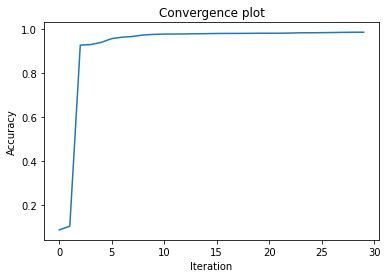

In [20]:
results = study.trials_dataframe()

results['value'].sort_values().reset_index(drop=True).plot()
plt.title('Convergence plot')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')

# Evaluate the model

In [21]:
# load best model

model = load_model(path_best_model)

In [22]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 14, 14, 64)        1664      
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 7, 7, 64)          102464    
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 4, 4, 64)          102464    
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 2, 2, 64)          0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 256)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 114)               29298     
_________________________________________________________________
dense_36 (Dense)             (None, 114)             

In [23]:
# make predictions in test set

result = model.evaluate(x=X_test,
                        y=y_test)

132/132 [==============================] - 1s 7ms/step - loss: 0.0597 - accuracy: 0.9821


In [24]:
# print evaluation metrics

for name, value in zip(model.metrics_names, result):
    print(name, value)

loss 0.05974521115422249
accuracy 0.9821428656578064


## Confusion matrix

In [25]:
# Predict the values from the validation dataset
y_pred = model.predict(X_test)

# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1)

# Convert validation observations to one hot vectors
y_true = np.argmax(y_test, axis = 1)

# compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes) 

cm

array([[416,   0,   0,   0,   1,   0,   2,   0,   3,   0],
       [  0, 466,   3,   0,   0,   0,   1,   2,   1,   0],
       [  2,   0, 405,   1,   0,   0,   0,   0,   1,   0],
       [  0,   0,   1, 419,   0,   1,   1,   3,   0,   1],
       [  1,   3,   0,   0, 419,   0,   3,   0,   0,   3],
       [  0,   0,   0,   1,   0, 376,   2,   0,   3,   0],
       [  0,   0,   0,   0,   2,   0, 409,   0,   1,   0],
       [  0,   2,   6,   1,   0,   1,   0, 457,   0,   2],
       [  0,   1,   1,   0,   0,   0,   1,   1, 379,   1],
       [  2,   2,   0,   4,   5,   0,   0,   1,   1, 379]], dtype=int64)

Text(0.5, 13.421126458070283, 'Predicted label')

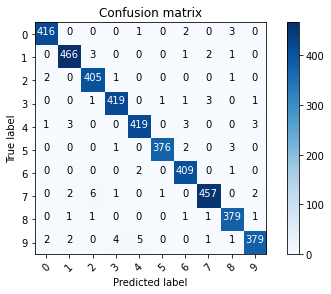

In [26]:
# let's make it more colourful
classes = 10

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(classes)
plt.xticks(tick_marks, range(classes), rotation=45)
plt.yticks(tick_marks, range(classes))

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > 100 else "black",
            )

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

Here we can see that our CNN performs very well on all digits.